In [1]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py


I2 = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
rho_0_anc = ket_0 @ ket_0.T
rho_1_anc = ket_1 @ ket_1.T

In [7]:
import sys
sys.path.append("../../src/brickwall_sparse")
from optimize_sparse import optimize
from utils_sparse import construct_heisenberg_local_term
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from qiskit.quantum_info import random_statevector
from scipy.sparse.linalg import expm_multiply

L = 6
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J = (1, 1, 1)
h = (1, 1, 1)
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix().toarray()
t = 0.5

hloc1 = construct_heisenberg_local_term((J[0], 0   ,    0), (0, h[1], 0))
hloc2 = construct_heisenberg_local_term((0   , J[1],    0), (0, 0, h[2]))
hloc3 = construct_heisenberg_local_term((0   , 0   , J[2]), (h[0], 0, 0))
hlocs = (hloc1, hloc2, hloc3)
Vs = [scipy.linalg.expm(-1j*t*hloc) if i==2 else scipy.linalg.expm(-1j*t*hloc/2)  for i, hloc in enumerate(hlocs)]
cs = [np.kron(X,  Z), np.kron(Z@Y, I2), np.kron(X@Z, I2), np.kron(I2, Z@X), np.kron(I2, Y@Z), np.kron(Z, X)]

Vlist_start = [cs[0], Vs[0], Vs[0], cs[1], Vs[1], Vs[1], cs[2], Vs[2], Vs[2], cs[3], Vs[1], Vs[1], cs[4], Vs[0], Vs[0], cs[5]]
Vlist_reduced = [Vs[0], Vs[0], Vs[1], Vs[1], Vs[2], Vs[2], Vs[1], Vs[1], Vs[0], Vs[0]]
control_layers = [0, 3, 6, 9, 12, 15] # 6 control layers
perms_extended = [[[i for i in range(L)]] if i%2==0 else [[i for i in range(1, L)]+[0]] for i in range(len(Vlist_start))]
perms_ext_reduced = []
for i, perm in enumerate(perms_extended):
    if i not in control_layers:
        perms_ext_reduced.append(perm)

state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist_start, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

Trotter error of the starting point:  0.8153257584267191


In [ ]:
from optimize_sparse import optimize

niter = 5
rS    = 6 
Vlist5, f_iter, err_iter = optimize(L, hamil, t, Vlist4, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, rS=rS, niter=niter)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [32]:
with h5py.File(f"./results/heisenberg1d_111_SPARSE_L{L}_t{t}_layers{len(Vlist)}_c{len(control_layers)}_niter55_rS6.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist5)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [36]:
"""with h5py.File(f"./results/heisenberg1d_111_SPARSE_L8_t0.5_layers16_c6.hdf5", "r") as file:
    Vlist_20 = file[f"Vlist"][:]"""

with h5py.File(f"./results/heisenberg1d_111_SPARSE_L6_t0.5_layers16_c6_niter50_rS6.hdf5", "r") as file:
    Vlist = file[f"Vlist"][:]

In [104]:
"""
    Test operations.
"""
L = 20
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J = (1, 1, 1)
h = (1, 1, 1)
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix()
t = 0.5
perms_extended = [[[i for i in range(L)]] if i%2==0 else [[i for i in range(1, L)]+[0]] for i in range(len(Vlist_start))]
perms_ext_reduced = []
for i, perm in enumerate(perms_extended):
    if i not in control_layers:
        perms_ext_reduced.append(perm)
Vlist_reduced = []
for i, V in enumerate(Vlist):
    if i not in control_layers:
        Vlist_reduced.append(V)

state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

Trotter error of the starting point:  0.08063759198961588


In [41]:
sys.path.append("../../src/controlled_unitary_optimizer")
sys.path.append("../../src/brickwall_ansatz")
from optimize_3q import optimize_3q 
from utils_3q import make_controlled, random_unitary

Xlists_opt = {}
perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]

for i in control_layers:
    cU = make_controlled(Vlist[i])
    f_best, err_best, Glist_best = (0, 2, None)
    for _ in range(10):
        Xlist_start = [random_unitary(4) for i in range(len(perms_qc))]
        Xlist, f_iter, err_iter = optimize_3q(L, cU, Xlist_start, perms_qc, niter=1000)
        if err_iter[-1] < err_best:
            f_best, err_best, Xlist_best = (f_iter[-1], err_iter[-1], Xlist)
    print("Best f: ", f_best)
    print("Best err: ", err_best)
    Xlists_opt[i] = Xlist_best

/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = rsq / dHd
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  rho = (f(x_next) - fx) / (np.dot(grad, eta) + 0.5 * np.dot(eta, hess @ eta))
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:40: RuntimeWarning: invalid value encountered in scalar divide
  rho = (f(x_next) - fx) / (np.dot(grad, eta) + 0.5 * np.dot(eta, hess @ eta))


Best f:  -7.999999999999914
Best err:  2.1303645529386208e-07
Best f:  -7.999999999999945
Best err:  1.9410247278359644e-07
Best f:  -7.999999999999815
Best err:  3.167975890834458e-07
Best f:  -7.999999999999922
Best err:  1.722490223784681e-07
Best f:  -7.999999999999921
Best err:  2.1426164010465294e-07
Best f:  -7.999999999999882
Best err:  2.3156602519077676e-07


In [42]:
# Save the optimal gates.

for i in control_layers:
    with h5py.File(f"./results/heisenberg1d_111_SPARSE_L6_t{t}_layers16_c6_niter50_rS6_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "w") as file:
        file.create_dataset(f"Xlist_{i}", data=Xlists_opt[i])

In [44]:
Xlists_opt1 = {}
for i in control_layers:
    with h5py.File(f"./results/heisenberg1d_111_SPARSE_L6_t{t}_layers16_c6_niter50_rS6_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt1[i] = file[f"Xlist_{i}"][:]

In [200]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp

qc = qiskit.QuantumCircuit(L+1)
qc.x(L)
for i, V in enumerate(Vlist):
    layer = i
    if i in control_layers:
        Glist = Xlists_opt[i]
        qc_3 = qiskit.QuantumCircuit(3)
        for j, G in enumerate(Glist):
            qc_3.unitary( G, (3-1-perms_qc[j][1], 3-1-perms_qc[j][0]))

        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.append(qc_3.to_gate(), [L-perm[2*j]-1, L-perm[2*j+1]-1, L])
        
    else:
        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.unitary(V, [L-perm[2*j]-1, L-perm[2*j+1]-1])
qc.x(L)


#ccU_cxs= []
#ccU_errs = []
for t in [1.5]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t/0.5)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t/0.5)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()
    
    ccU_errs.append(err)
    ccU_cxs.append(count_ops['unitary'])
    print(f"t={t}, Gate Count: ", count_ops['unitary'], " Trotter error: ", err)

/tmp/ipykernel_1296/3497514686.py:38: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
/tmp/ipykernel_1296/3497514686.py:46: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data


t=1.5, Gate Count:  1920  Trotter error:  0.16659943098685642


In [208]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=10 system.
"""


def uncompr_trotterized_time_evolution(qc, hlocs, t, gate, lamb=None):
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set
    
    K_layer = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer[perms[0][2*j]] = gate[0]
        K_layer[perms[0][2*j+1]] = gate[1]
        
    K_b = [K_layer, None]
    K_a = [None, K_layer]
    
    Vlists = [[scipy.linalg.expm(-1j*t*hloc) for i in range(len(perm_set))] for hloc in hlocs]
    Vlists_gates = [[] for _ in hlocs]
    for i, Vlist in enumerate(Vlists):
        for V in Vlist:
            qc2 = qiskit.QuantumCircuit(2)
            qc2.unitary(V, [0, 1], label='str')
            Vlists_gates[i].append(qc2)


    for layer in range(len(perms)):
        if K_b[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_b[layer][j] is not None:
                    qc.append(K_b[layer][j](), [L, L-1-j])
            qc.x(L)

            
        for Vlist_gates in Vlists_gates:
            qc_gate = Vlist_gates[layer]
            
            for j in range(len(perms[layer])//2):
                    qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                                    L-(perms[layer][2*j+1]+1)])

        if K_a[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_a[layer][j] is not None:
                    qc.append(K_a[layer][j](), [L, L-1-j])
            qc.x(L)


def uncompr_controlled_trotter(c1, c2, L, J, h=(0,0,0), dagger=False, nsteps=1, trotter_degree=2):
    if c1/(2*nsteps) > 0.1:
        nsteps = int(np.ceil(c1/(2 * 0.1)))
    dt = c1/(2*nsteps)
    t = c1/2
    
    hloc1 = construct_heisenberg_local_term((J[0], 0   ,    0), (0, h[1],    0))
    hloc2 = construct_heisenberg_local_term((0   ,    J[1], 0), (0, 0, h[2]   ))
    hloc3 = construct_heisenberg_local_term((0   , 0   , J[2]), (h[0], 0,    0))
    qc_cU_ins = qiskit.QuantumCircuit(L+1)

    if dagger:
        qc_cU_ins.x(L)

    hs = ((hloc1,), (hloc2,), (hloc3,))
    cgates = ((CXGate, CZGate), 
              (CXGate, CYGate), 
              (CZGate, CYGate))

    # Trotter 2nd Order.
    indices = [0, 1, 2, 1, 0]
    coeffs  = [0.5, 0.5, 1, 0.5, 0.5]
    if trotter_degree==1:
        # Trotter 1st Order.
        indices = [0, 1, 2]
        coeffs  = [1, 1, 1]
    if trotter_degree==4:
        # Trotter 4th Order.
        indices = [0, 1, 2, 1, 0, 1, 2, 1, 0]
        coeffs  = [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25]
        
    for n in range(nsteps):
        for index, coef in zip(indices, coeffs):
            uncompr_trotterized_time_evolution(qc_cU_ins, hs[index], dt * coef, cgates[index])

    qc_cU_ins.cp(-c2, L,  0)
    qc_cU_ins.x(0)
    qc_cU_ins.cp(-c2, L, 0)
    qc_cU_ins.x(0)

    if dagger:
        qc_cU_ins.x(L)

    return qc_cU_ins
    
trotter2_cxs= []
trotter2_errs = []
for t in [0.5, 1, 1.5, 2]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    qc_ext1.append(uncompr_controlled_trotter(2*t, 0, L, J, h, trotter_degree=2).to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    qc_ext2.append(uncompr_controlled_trotter(2*t, 0, L, J, h, trotter_degree=2).to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()

    trotter2_cxs.append(count_ops['cx']+count_ops['unitary'])
    trotter2_errs.append(err)

    print(f"t={t}, Gate Count: ", count_ops['cx']+count_ops['unitary'], " Trotter error: ", err)

/tmp/ipykernel_1296/82421771.py:109: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
/tmp/ipykernel_1296/82421771.py:116: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data


t=0.5, Gate Count:  1500  Trotter error:  0.1807771842225962
t=1, Gate Count:  3000  Trotter error:  0.30265263944132426
t=1.5, Gate Count:  4500  Trotter error:  0.38777533456822233
t=2, Gate Count:  6000  Trotter error:  0.45531193293427574


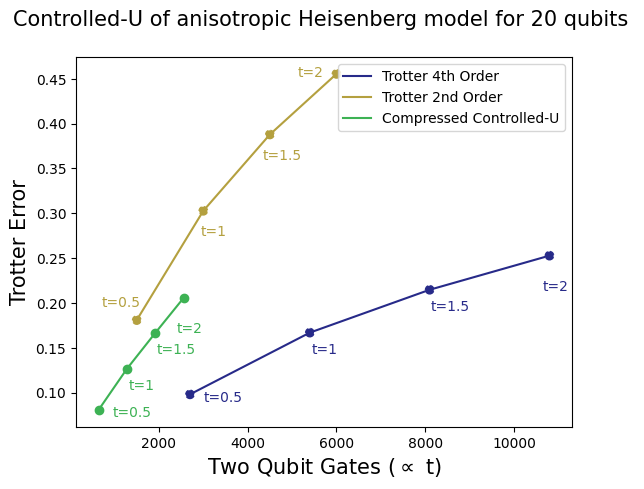

In [254]:
color1 = (39/256, 42/256  , 138/256)
color2 = (61/256, 179/256 , 84/256 )
color3 = (181/256, 161/256, 63/256 )
plt.xlabel(r'Two Qubit Gates ($\propto$ t)', size=15)
plt.ylabel('Trotter Error', size=15)
plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45])

plt.plot(trotter4_cxs, trotter4_errs, label=r"Trotter 4th Order", color=color1)
plt.scatter(trotter4_cxs, trotter4_errs, ls='--', color=color1)
plt.plot(trotter2_cxs, trotter2_errs, label=r"Trotter 2nd Order", color=color3)
plt.scatter(trotter2_cxs, trotter2_errs, ls='--', color=color3)
plt.plot(ccU_cxs, ccU_errs, label=r"Compressed Controlled-U", color=color2)
plt.scatter(ccU_cxs, ccU_errs, color=color2)

annotations = [("t=0.5", (10, -5)), ("t=1", (1, -15)), ("t=1.5", (1, -15)), ("t=2", (-5, -25))]
for xi, yi, text in zip(trotter4_cxs, trotter4_errs, annotations):
    plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=color1)
    
annotations = [("t=0.5", (10, -5)), ("t=1", (1, -15)), ("t=1.5", (1, -15)), ("t=2", (-5, -25))]
for xi, yi, text in zip(ccU_cxs, ccU_errs, annotations):
    plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=color2)

annotations = [("t=0.5", (-25, 10)), ("t=1", (-2, -18)), ("t=1.5", (-5, -18)), ("t=2", (-28, -2))]
for xi, yi, text in zip(trotter2_cxs, trotter2_errs, annotations):
    plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=color3)

plt.legend(loc="upper right", prop={'size': 10})
#plt.xscale('log')
plt.title("Controlled-U of anisotropic Heisenberg model for 20 qubits \n", size=15)
#plt.savefig('./figs/heisenberg1d_111_trotter_and_cxs.pdf', dpi=300)
plt.savefig('./figs/heisenberg1d_111_trotter_and_cxs.png', dpi=300)
plt.show()

In [221]:
print(trotter2_cxs, trotter2_errs, '\n')

print(trotter4_cxs, trotter4_errs, '\n')

print(ccU_cxs, ccU_errs)

[1500, 3000, 4500, 6000] [0.1807771842225962, 0.30265263944132426, 0.38777533456822233, 0.45531193293427574] 

[2700, 5400, 8100, 10800] [0.09796044777174191, 0.1667859590777272, 0.2146021833049138, 0.2526482471716145] 

[640, 1280, 1920, 2560] [0.08059105781840381, 0.12653934797482738, 0.16659943098685642, 0.20574073191569148]
